# DR CRC Calibration

Author: Sophie Wagner, sw3767@cumc.columbia.edu

In [1]:
# Required Packages
import numpy as np  # For matrix manipulation
import pandas as pd  # For output/input data processing
import matplotlib.pyplot as plt  # For visualizations
from csaps import csaps
from scipy.interpolate import interp1d
from tqdm import tqdm
from datetime import datetime

# Add the src directory to the Python path
import sys
import os
sys.path.append(os.path.abspath('../src'))

# Load .py files
import common_functions as func
import calibration_plots as p
import configs as c
import gof


# Some aesthetic options
np.set_printoptions(suppress=True, linewidth=300, formatter={'float': '{: 0.9f}'.format})
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Matrix setup, normalization, constraints

In [2]:
def row_normalize(matrix):
    for age_layer in range(matrix.shape[0]):  # Loop over each age layer
        layer = matrix[age_layer]
        # Calculate the sum of non-diagonal elements for each row
        sum_of_columns = np.sum(layer, axis=1) - np.diag(layer)
        # Set the diagonal elements
        np.fill_diagonal(layer, 1 - sum_of_columns)
    return matrix


def create_matrix():
    matrix = np.zeros((len(c.age_layers), len(c.health_states), len(c.health_states)))
    matrix[:, 0, 1] = func.probtoprob(0.005)  # Healthy to LR
    matrix[:, 1, 2] = func.probtoprob(0.015)  # LR to HR
    matrix[:, 2, 3] = func.probtoprob(0.05)  # HR to uLoc
    matrix[:, 3, 4] = func.probtoprob(0.45)  # uLoc to uReg
    matrix[:, 4, 5] = func.probtoprob(0.50)  # uReg to uDis
    matrix[:, 3, 6] = func.probtoprob(0.20)  # uLoc to dLoc
    matrix[:, 4, 7] = func.probtoprob(0.60)  # uReg to dReg
    matrix[:, 5, 8] = func.probtoprob(0.90)  # uDis to dDis

    matrix = add_acm(matrix)  # ACM
    matrix = add_csd(matrix)  # CSD
    matrix = constrain_matrix(matrix)  # constrain
    matrix = row_normalize(matrix)  # normalize

    return matrix

locreg=func.probtoprob(0.2)
def constrain_matrix(matrix):
    matrix = np.clip(matrix, 0.0, 0.5)

    # Progression Block
    matrix[:, 0, 1] = np.maximum(0.000001, matrix[:, 0, 1])  # not below 0
    matrix[:, 1, 2] = np.maximum(matrix[:, 0, 1], matrix[:, 1, 2])  
    matrix[:, 2, 3] = np.maximum(matrix[:, 1, 2], matrix[:, 2, 3])
    matrix[:, 3, 4] = np.maximum(locreg, matrix[:, 3, 4])
    matrix[:, 3, 4] = np.maximum(matrix[:, 2, 3], matrix[:, 3, 4])
    matrix[:, 4, 5] = np.maximum(matrix[:, 3, 4], matrix[:, 4, 5])

    # Detection Block
    matrix[:, 3, 6] = np.maximum(0.000001, matrix[:, 3, 6])
    matrix[:, 4, 7] = np.maximum(matrix[:, 3, 6], matrix[:, 4, 7])
    matrix[:, 5, 8] = np.maximum(matrix[:, 4, 7], matrix[:, 5, 8])
    
    # Age dependencies
    matrix[:, 0, 1] = np.maximum.accumulate(matrix[:,0,1])
    # matrix[:, 1, 2] = np.maximum.accumulate(matrix[:,0,1])
    # matrix[:, 2, 3] = np.maximum.accumulate(matrix[:,0,1])

    return matrix


def add_acm(matrix):
    matrix[:, 0, 10] = c.acm_rate  # Healthy to ACM
    matrix[:, 1:3, 12] = c.acm_rate[:, np.newaxis]  # Polyp to ACM
    matrix[:, 3:6, 13] = c.acm_rate[:, np.newaxis]  # Undiagnosed to ACM
    matrix[:, 6:9, 11] = c.acm_rate[:, np.newaxis]  # Cancer to ACM
    matrix[:, 9, 9] = 1  # Stay in CSD
    matrix[:, 10, 10] = 1  # Stay in ACM
    matrix[:, 11, 11] = 1  # Stay in Cancer ACM
    matrix[:, 12, 12] = 1  # Stay in Polyp ACM
    matrix[:, 13, 13] = 1  # Stay in uCRC ACM

    return matrix


def add_csd(matrix):
    matrix[:, 6, 9] = c.csd_rate[:, 0]
    matrix[:, 7, 9] = c.csd_rate[:, 1]
    matrix[:, 8, 9] = c.csd_rate[:, 2]
    return matrix

### Markov model

In [3]:
def run_markov(matrix, starting_age=20, max_age=84):
    
    current_age = starting_age
    stage, age_layer = 1, 0
    month_pop, pop_log = c.starting_pop, c.starting_pop
    inc_log = np.zeros(pop_log.shape)  # to track new incidences in each state
    matrixT = matrix.transpose(0,2,1)
    inflow_matrix = np.tril(matrixT, k=-1)
    
    while current_age <= max_age:
        
        # Matrix multiplication (state transition)
        mat, inflow_mat = matrixT[age_layer], inflow_matrix[age_layer] 
        month_inc = np.matmul(inflow_mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        month_pop = np.matmul(mat, month_pop)  # (9, 9)(9, 1)->(9, 1)
        
        # Add to log
        inc_log = np.concatenate((inc_log, month_inc), axis=1)
        pop_log = np.concatenate((pop_log, month_pop), axis=1)
        
        stage += 1
        if stage % 12 == 0:
            current_age += 1
            if current_age in c.ages_5y: 
                age_layer = min(age_layer+1, 13)

    incidence = inc_log.copy()  # make (14,960)
    dead_factor = np.divide(c.N, c.N - pop_log[9:, :].sum(axis=0))  # inc and prev denominator is out of living only
    prevalence = np.zeros(pop_log.shape)  # (14,80)

    for state in range(14):
        incidence[state, :] = np.multiply(incidence[state, :], dead_factor)
        prevalence[state, :] = np.multiply(pop_log[state, :], dead_factor)

    incidence = incidence.reshape(len(c.health_states), 81, 12).sum(axis=2)  # getting annual incidence (rate per 100k)
    incidence_unadj = inc_log.reshape(len(c.health_states), 81, 12).sum(axis=2)  # getting inc unadjusted
    prevalence = prevalence.reshape(len(c.health_states), 81, 12).mean(axis=2)  # getting mean annual prevalence
    
    return incidence, prevalence, incidence_unadj, pop_log

### Simulated annealing

In [14]:
def step(matrix, step_size, num_adj=5):
    new_matrix = np.copy(matrix)
    step_mat = np.random.choice(len(points), size=num_adj, replace=True)
    step_age = np.random.choice(len(c.age_layers_5y), size=num_adj, replace=True)
    small_matrix = new_matrix[2:65:5, :, :]  # (13, 14, 14)

    for i in range(num_adj):
        (from_state, to_state) = points[step_mat[i]]
        step_param = np.mean(small_matrix[:, from_state, to_state]) * step_size
        small_matrix[step_age[i], from_state, to_state] += np.random.uniform(low=-step_param, high=step_param)
    
    # Calculate the anchor (mean across ages)
    anchor = small_matrix.mean(axis=0)  # (14, 14)
    anchor_expanded = np.expand_dims(anchor, axis=0)  # (1, 14, 14)
    anchored_matrix = np.append(small_matrix, anchor_expanded, axis=0)  # (14, 14, 14)
    
    #small_matrix[12,:,:] = np.minimum(small_matrix[11,:],small_matrix[12,:,:])  # Limit potential increase before splining
    
    new_matrix = csaps([22.5,27.5,32.5,37.5,42.5,47.5,52.5,57.5,62.5,67.5,72.5,77.5,82.5,100], anchored_matrix, smooth=0.01, axis=0)(np.arange(20,100,1)).clip(0.0,1.0)
    
    new_matrix = constrain_matrix(new_matrix)
    new_matrix = add_acm(new_matrix)
    new_matrix = add_csd(new_matrix)
    new_matrix = row_normalize(new_matrix)

    return new_matrix

In [5]:
def progress_report(iteration, best_eval, best_log, ticker, best_t):
    """
    Prints progress report during simulated annealing.
    """
    log_adj, _, inc_log, _ = best_log
    total_dxd = np.sum(inc_log[6:9, :]) / c.N
    total_pol = np.sum(inc_log[12, :]) / c.N 
    print(f"{iteration}: Best Eval: {best_eval:.5f}, CRC: {total_dxd:.5f}, Polyp: {total_pol:.5f}, Tick: {ticker}")

    if iteration % 50000 == 0:
        transition_probs = p.extract_transition_probs(best_t, c.health_states, c.desired_transitions)
        print(f"Detailed Progress Report, Iteration = {iteration}")
        p.print_trans_probs(transition_probs)

In [6]:
def simulated_annealing(n_iterations, step_size, start_tmat=None, n_adj=7, verbose=False, starting_temp=1, print_interval=2500, obj=""):
    """
    Performs simulated annealing to optimize a transition matrix.

    Args:
        n_iterations (int): Number of iterations for optimization.
        step_size (float): Step size for parameter adjustments.
        start_tmat (numpy.ndarray): Initial transition matrix.
        n_adj (int): Number of parameters to adjust per step.
        starting_temp (float): Initial temperature for annealing.
        verbose (bool): Whether to print progress reports.
        print_interval (int): Interval for progress reporting.

    Returns:
        numpy.ndarray: Optimized transition matrix.
    """
    best_t = np.copy(start_tmat)
    best_log = run_markov(best_t)
    best_eval = gof.objective(run_markov(start_tmat), -1, obj)
    curr_t, curr_eval = best_t, best_eval
    ticker = 0

    with tqdm(total=n_iterations, desc="Simulated annealing progress", unit="iteration") as pbar:
        
        for i in range(n_iterations):

            # Run model
            candidate_t = np.copy(curr_t)
            candidate_t = step(candidate_t, step_size, n_adj)
            candidate_log = run_markov(candidate_t)
            candidate_eval = gof.objective(candidate_log, i, obj)  # Evaluate candidate point

            # Update "best" if better than candidate
            if candidate_eval < best_eval:
                ticker = 0
                best_t, best_eval = np.copy(candidate_t), np.copy(candidate_eval)
                best_log = run_markov(best_t)

            else:
                ticker += 1

            # Calculate temperature and Metropolis acceptance criterion
            t = starting_temp / (1 + np.log(i + 1))
            diff = candidate_eval - curr_eval
            metropolis = np.exp(-diff / t)

            if diff < 0 or np.random.random() < metropolis:
                curr_t, curr_eval = np.copy(candidate_t), candidate_eval

            # Print progress report
            if verbose and i > 0 and i % print_interval == 0:
                progress_report(i, best_eval, best_log, ticker, best_t)

            # Check if we should update "curr"
            diff = (candidate_eval - curr_eval)  # difference between candidate and current point evaluation
            metropolis = np.exp(-diff / t)  # calculate metropolis acceptance criterion
            if (diff < 0 or np.random.random() < metropolis):  # check if we should keep the new point
                curr_t, curr_eval = np.copy(candidate_t), np.copy(candidate_eval)  # store the new current point
                ticker = 0

            pbar.update(1)

    print("Final score: ", best_eval)
    
    return best_t

In [7]:
def run_sa(tmat=None, save_all=False, n_iterations=50000, step_size=0.2, n_adj=5, obj=""):
    
    start_tmat = None
    start_tmat = tmat if tmat is not None else create_matrix()   
    initial_score = gof.objective(run_markov(start_tmat), -1, obj)
    print(f"Initial score: {round(initial_score, 5)}")
    # print("Starting calibration...")
    
    result = simulated_annealing(n_iterations=n_iterations, step_size=step_size, start_tmat=tmat, n_adj=n_adj, verbose=True, obj=obj)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M")
    
    curr_tmat = result.copy()
    curr_log = run_markov(curr_tmat)

    # Extract transition probabilities
    transition_probs = p.extract_transition_probs(curr_tmat, c.health_states, c.desired_transitions)

    # Saving
    if save_all:
        # Save the with the timestamp in the filenames
        tmat_path, plot_path, probs_path = c.OUTPUT_PATHS["tmats"], c.OUTPUT_PATHS["plots"], c.OUTPUT_PATHS["probs"]
        np.save(f"{tmat_path}/{timestamp}_tmat.npy", curr_tmat)

        p.print_trans_probs(transition_probs, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        p.print_trans_probs(transition_probs)
        p.plot_tps(curr_tmat, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        p.plot_vs_seer_total(curr_log, c.seer_inc, save_imgs=True, outpath=plot_path, timestamp=timestamp)
        
        out = np.zeros((len(c.points), 80))
        for idx, (from_state, to_state) in enumerate(c.points):
            out[idx] = curr_tmat[:, from_state, to_state]

        pd.DataFrame(out).to_csv(f"{probs_path}/{timestamp}_tps.csv")

    # else:
        # p.print_trans_probs(transition_probs)
        # p.plot_tps(curr_tmat)
        # p.plot_vs_seer(curr_log, c.seer_inc)
        # p.plot_vs_seer_total(curr_log, c.seer_inc)

    return curr_tmat

## Run SA

1/2/2025 10am: Using our US 1243 model, calibrate to DR incidence and HGPS stage distribution. 

1/3/2025 5am: Using 2148 model, calibrate to 2x inc and 2x polyp prev

1/3/2025 6am: Using 2148 model with (0,1)x2

1/3/2025 7am: Using 2148 model with (0,1)/2

In [8]:
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

DR, SEER:: incidence 0.5 | polyp 0.5


In [10]:
t1=np.load("../out/DR/SEER_I1_P1/tmats/20240923_1746_tmat.npy")
result = np.copy(t1)
result[:, 0, 1] *= 0.5
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

n_iterations=10000
n_iters=1
n_epochs=3

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/{n_epochs} -----------------------------------------------------------------------------")
    for iter in range(n_iters): 
        print(f"ITER {iter+1}/{n_iters} ----------------------------------------------")
        save = True if iter==n_iters-1 else False
        result = run_sa(result, save, n_iterations=n_iterations, step_size = 0.15, n_adj=5, obj="pol")
    
    curr = run_markov(result) 
    progress_report(epoch, gof.objective(curr, -1, ""), curr, 0, result)
    
print("DONE")

DR, SEER:: incidence 0.5 | polyp 0.5
EPOCH 1/3 -----------------------------------------------------------------------------
ITER 1/1 ----------------------------------------------
Initial score: 53.17217


Simulated annealing progress:  25%|██▌       | 2515/10000 [01:23<01:53, 66.11iteration/s]

2500: Best Eval: 51.11002, CRC: 0.01072, Polyp: 0.03779, Tick: 845


Simulated annealing progress:  50%|█████     | 5005/10000 [02:42<03:36, 23.09iteration/s]

5000: Best Eval: 51.11002, CRC: 0.01072, Polyp: 0.03779, Tick: 3345


Simulated annealing progress:  75%|███████▌  | 7511/10000 [03:49<00:34, 73.15iteration/s]

7500: Best Eval: 51.11002, CRC: 0.01072, Polyp: 0.03779, Tick: 5845


Simulated annealing progress: 100%|██████████| 10000/10000 [05:05<00:00, 32.71iteration/s]


Final score:  51.11002358626962
Monthly transition probabilities
healthy to LR_polyp: Min: 0.00003, Max: 0.00011, Average: 0.00009
LR_polyp to HR_polyp: Min: 0.00101, Max: 0.00227, Average: 0.00185
HR_polyp to u_CRC_loc: Min: 0.00242, Max: 0.00505, Average: 0.00421
u_CRC_loc to u_CRC_reg: Min: 0.02804, Max: 0.03886, Average: 0.03442
u_CRC_reg to u_CRC_dis: Min: 0.04119, Max: 0.07441, Average: 0.05271
u_CRC_loc to d_CRC_loc: Min: 0.01331, Max: 0.02192, Average: 0.01887
u_CRC_reg to d_CRC_reg: Min: 0.06271, Max: 0.08753, Average: 0.07945
u_CRC_dis to d_CRC_dis: Min: 0.14710, Max: 0.24225, Average: 0.18796

Annual transition probabilities
healthy to LR_polyp: Min: 0.00034, Max: 0.00135, Average: 0.00104
LR_polyp to HR_polyp: Min: 0.01207, Max: 0.02692, Average: 0.02191
HR_polyp to u_CRC_loc: Min: 0.02862, Max: 0.05894, Average: 0.04937
u_CRC_loc to u_CRC_reg: Min: 0.28916, Max: 0.37851, Average: 0.34249
u_CRC_reg to u_CRC_dis: Min: 0.39634, Max: 0.60461, Average: 0.47399
u_CRC_loc to d_CR

Simulated annealing progress: 100%|██████████| 10000/10000 [03:42<00:00, 44.91iteration/s]


In [15]:
# All points
# result = run_sa(result, False, n_iterations=1000, step_size = 0.05, n_adj=5, obj="pol")

# Only Healthy to LR
result = run_sa(result, True, n_iterations=5000, step_size = 0.10, n_adj=2, obj="pol")
# result = run_sa(result, True, n_iterations=10, step_size = 0.10, n_adj=5, obj="pol")

Simulated annealing progress: 100%|██████████| 5000/5000 [02:15<00:00, 37.01iteration/s]


In [ ]:
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

n_iterations=10000
n_iters=1
n_epochs=3

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/n_epochs -----------------------------------------------------------------------------")
    for iter in range(n_iters):
        print(f"ITER {iter+1}/n_iters ----------------------------------------------")
        save = True if iter==n_iters-1 else False
        result = run_sa(result, save, n_iterations=n_iterations, step_size = 0.15, n_adj=5, obj="pol")
    
    curr = run_markov(result) 
    progress_report(epoch, gof.objective(curr, -1, ""), curr, 0, result)
    
print("DONE")

In [ ]:
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

n_iterations=10000
n_iters=1
n_epochs=3

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/n_epochs -----------------------------------------------------------------------------")
    for iter in range(n_iters):
        print(f"ITER {iter+1}/n_iters ----------------------------------------------")
        save = True if iter==n_iters-1 else False
        result = run_sa(result, save, n_iterations=n_iterations, step_size = 0.1, n_adj=2, obj="pol")
    
    curr = run_markov(result)
    progress_report(epoch, gof.objective(curr, -1, ""), curr, 0, result)
    
print("DONE")

Now, using smaller step size, allow iteration of all params? 

In [16]:
result=np.load("../out/DR/HGPS_I0.5_P0.5/tmats/20250103_0741_tmat.npy")
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

n_iterations=10000
n_iters=1
n_epochs=2

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/n_epochs -----------------------------------------------------------------------------")
    for iter in range(n_iters):
        print(f"ITER {iter+1}/n_iters ----------------------------------------------")
        save = True if iter==n_iters-1 else False
        result = run_sa(result, save, n_iterations=n_iterations, step_size = 0.05, n_adj=5, obj="pol")
    
    curr = run_markov(result)
    progress_report(epoch, gof.objective(curr, -1, ""), curr, 0, result)
    
print("DONE")

Simulated annealing progress: 100%|██████████| 10000/10000 [04:55<00:00, 33.90iteration/s]


In [12]:
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")

n_iterations=10000
n_iters=1
n_epochs=2

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/n_epochs -----------------------------------------------------------------------------")
    for iter in range(n_iters):
        print(f"ITER {iter+1}/n_iters ----------------------------------------------")
        save = True if iter==n_iters-1 else False
        result = run_sa(result, save, n_iterations=n_iterations, step_size = 0.15, n_adj=5, obj="pol")
    
    curr = run_markov(result)
    progress_report(epoch, gof.objective(curr, -1, ""), curr, 0, result)
    
print("DONE")

DR, HGPS:: incidence 2 | polyp 2
EPOCH 1/n_epochs -----------------------------------------------------------------------------
ITER 1/n_iters ----------------------------------------------
Initial score: 32758.5546


Simulated annealing progress:  25%|██▌       | 2502/10000 [00:51<05:52, 21.27iteration/s]

2500: Best Eval: 32758.55460, CRC: 0.03358, Polyp: 0.16665, Tick: 2501


Simulated annealing progress:  50%|█████     | 5012/10000 [02:43<01:10, 70.93iteration/s]

5000: Best Eval: 32758.55460, CRC: 0.03358, Polyp: 0.16665, Tick: 5001


Simulated annealing progress:  75%|███████▌  | 7508/10000 [03:59<00:34, 71.77iteration/s]

7500: Best Eval: 32758.55460, CRC: 0.03358, Polyp: 0.16665, Tick: 7501


Simulated annealing progress: 100%|██████████| 10000/10000 [05:13<00:00, 31.86iteration/s]


Final score:  32758.554602409786
Monthly transition probabilities
healthy to LR_polyp: Min: 0.00035, Max: 0.00035, Average: 0.00035
LR_polyp to HR_polyp: Min: 0.00034, Max: 0.00198, Average: 0.00127
HR_polyp to u_CRC_loc: Min: 0.00246, Max: 0.00368, Average: 0.00306
u_CRC_loc to u_CRC_reg: Min: 0.02959, Max: 0.04849, Average: 0.03515
u_CRC_reg to u_CRC_dis: Min: 0.04358, Max: 0.06863, Average: 0.06145
u_CRC_loc to d_CRC_loc: Min: 0.01250, Max: 0.01716, Average: 0.01591
u_CRC_reg to d_CRC_reg: Min: 0.04171, Max: 0.09513, Average: 0.05374
u_CRC_dis to d_CRC_dis: Min: 0.17279, Max: 0.30496, Average: 0.21398

Annual transition probabilities
healthy to LR_polyp: Min: 0.00418, Max: 0.00418, Average: 0.00418
LR_polyp to HR_polyp: Min: 0.00406, Max: 0.02354, Average: 0.01508
HR_polyp to u_CRC_loc: Min: 0.02910, Max: 0.04330, Average: 0.03613
u_CRC_loc to u_CRC_reg: Min: 0.30259, Max: 0.44925, Average: 0.34773
u_CRC_reg to u_CRC_dis: Min: 0.41414, Max: 0.57396, Average: 0.53054
u_CRC_loc to d_C

Simulated annealing progress: 100%|██████████| 10000/10000 [05:08<00:00, 32.38iteration/s]


In [ ]:
result = np.load("../out/DR/HGPS_I2_P2/tmats/20240924_2148_tmat.npy")

Generate CRC and polyp incidence

In [8]:
result=np.load("../out/DR/HGPS_I0.5_P0.5/tmats/20250103_0816_tmat.npy")
inc_adj, _, inc_log, _ = run_markov(result)
total_dxd = np.sum(inc_log[6:9, :]) / c.N
total_pol = np.sum(inc_log[12, :]) / c.N 
print(f"CRC: {total_dxd:.5f}, Polyp: {total_pol:.5f}")

transition_probs = p.extract_transition_probs(result, c.health_states, c.desired_transitions)
p.print_trans_probs(transition_probs)
print("Score: ", gof.objective(run_markov(result),-1,"pol"))
# pop_log = run_markov(result)[-1]
# pd.DataFrame(pop_log).to_csv("../out/DR/HGPS_I1_P2/logs/20250102_1545_pop_log.csv")

CRC: 0.01168, Polyp: 0.03781
Monthly transition probabilities
healthy to LR_polyp: Min: 0.00008, Max: 0.00008, Average: 0.00008
LR_polyp to HR_polyp: Min: 0.00056, Max: 0.00225, Average: 0.00179
HR_polyp to u_CRC_loc: Min: 0.00260, Max: 0.00451, Average: 0.00352
u_CRC_loc to u_CRC_reg: Min: 0.03089, Max: 0.04884, Average: 0.03640
u_CRC_reg to u_CRC_dis: Min: 0.04696, Max: 0.06863, Average: 0.06101
u_CRC_loc to d_CRC_loc: Min: 0.01247, Max: 0.01701, Average: 0.01583
u_CRC_reg to d_CRC_reg: Min: 0.04116, Max: 0.09817, Average: 0.05676
u_CRC_dis to d_CRC_dis: Min: 0.17339, Max: 0.31699, Average: 0.22281

Annual transition probabilities
healthy to LR_polyp: Min: 0.00090, Max: 0.00095, Average: 0.00095
LR_polyp to HR_polyp: Min: 0.00668, Max: 0.02664, Average: 0.02127
HR_polyp to u_CRC_loc: Min: 0.03081, Max: 0.05278, Average: 0.04144
u_CRC_loc to u_CRC_reg: Min: 0.31377, Max: 0.45169, Average: 0.35800
u_CRC_reg to u_CRC_dis: Min: 0.43854, Max: 0.57396, Average: 0.52831
u_CRC_loc to d_CRC_l

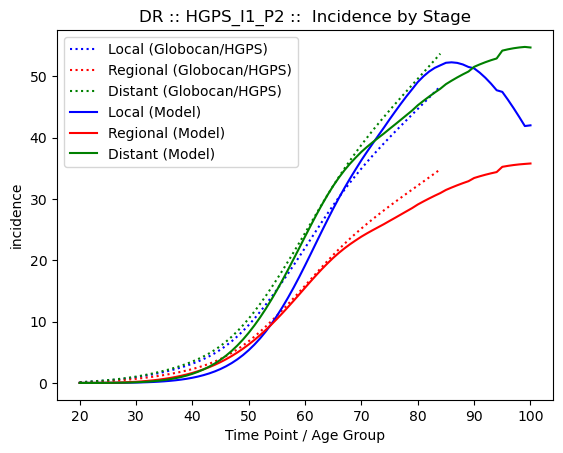

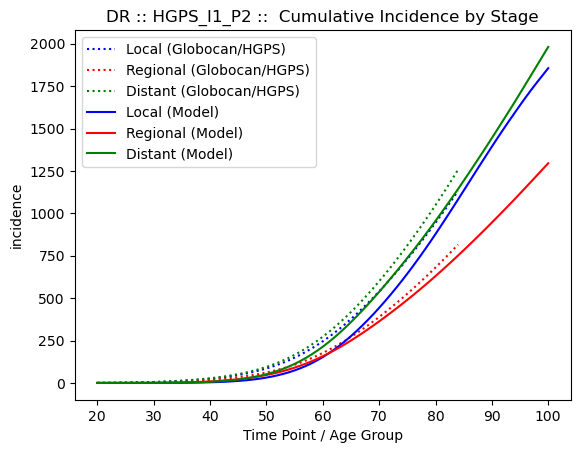

In [14]:
temp = result.copy()
temp[:,4,7] = t1[:,4,7]
temp[:,3,4] = t1[:,3,4]
temp[:,4,5] = t1[:,4,5]

new_matrix = constrain_matrix(temp)
new_matrix = add_acm(new_matrix)
new_matrix = add_csd(new_matrix)
new_matrix = row_normalize(new_matrix)
p.plot_vs_seer(run_markov(new_matrix), c.seer_inc)

What if we only allow the parameters healthy-> LR, LR-> HR, and HR-> uLoc to change?

In [10]:
inc_log = run_markov(t1)[-2]
total_dxd = np.sum(inc_log[6:9, :]) / c.N
total_pol = np.sum(inc_log[12, :]) / c.N 
total_uCRC = np.sum(inc_log[13, :]) / c.N 
print(f"CRC: {total_dxd:.5f}, Polyp: {total_pol:.5f}, uCRC: {total_uCRC:.5f}")

CRC: 0.02343, Polyp: 0.07564, uCRC: 0.00263


In [11]:
result = np.load("../out/DR/HGPS_I1_P2/tmats/20250102_1754_tmat.npy")
inc_log = run_markov(result)[-2]
total_dxd = np.sum(inc_log[6:9, :]) / c.N
total_pol = np.sum(inc_log[12, :]) / c.N 
total_uCRC = np.sum(inc_log[13, :]) / c.N 
print(f"CRC: {total_dxd:.5f}, Polyp: {total_pol:.5f}, uCRC: {total_uCRC:.5f}")


CRC: 0.02226, Polyp: 0.23839, uCRC: 0.00263


In [12]:
c.polyp_targets

array([ 0.005829475,  0.150733556,  0.156563031])

In [8]:
result = np.load("../out/DR/HGPS_I1_P2/tmats/20250102_1830_tmat.npy")
inc_log = run_markov(result)[-2]
total_dxd = np.sum(inc_log[6:9, :]) / c.N
total_pol = np.sum(inc_log[12, :]) / c.N 
total_uCRC = np.sum(inc_log[13, :]) / c.N 
print(f"CRC: {total_dxd:.5f}, Polyp: {total_pol:.5f}, uCRC: {total_uCRC:.5f}")

CRC: 0.02327, Polyp: 0.15339, uCRC: 0.00256


## For later

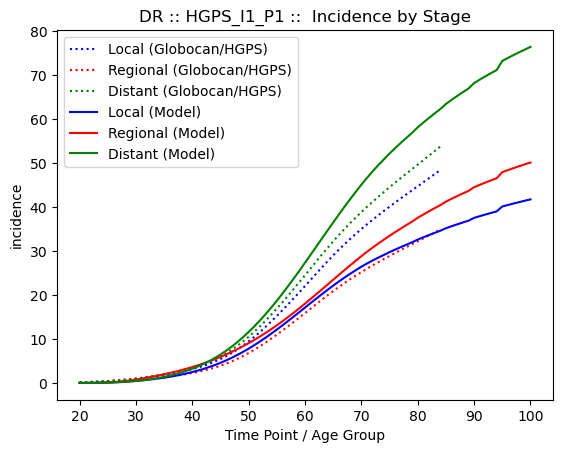

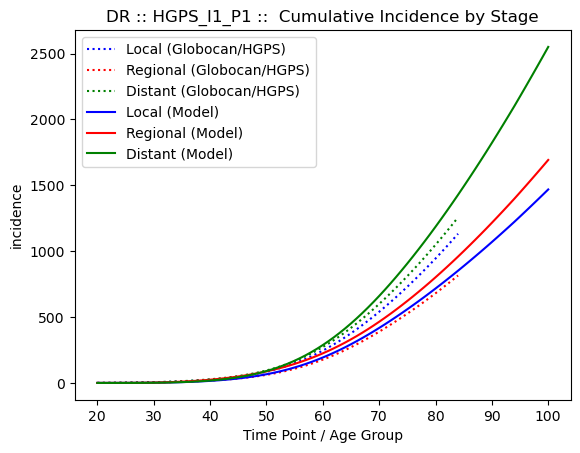

In [8]:
t1 = np.load("../out/DR/HGPS_I1_P1/tmats/20240924_2148_tmat.npy")
temp = np.copy(t1)
temp[:, 3, 4] = temp[:,4,5].clip(None, func.probtoprob(0.45))
temp[:, 4, 5] = temp[:,4,5].clip(func.probtoprob(0.45), None)

new_matrix = constrain_matrix(temp)
new_matrix = add_acm(new_matrix)
new_matrix = add_csd(new_matrix)
new_matrix = row_normalize(new_matrix)
p.plot_vs_seer(run_markov(new_matrix), c.seer_inc)

Fix transition probs with 2148 matrix s.t. they are more logical
- Only increasing healhty to LR
- Progression probs with loc->reg < reg -> dis

In [13]:
result = new_matrix.copy()
print(f"{c.model_version}, {c.stage}:: incidence {c.inc_factor} | polyp {c.polyp_factor}")
n_epochs=1

for epoch in range(n_epochs):
    print(f"EPOCH {epoch+1}/n_epochs -----------------------------------------------------------------------------")
    result = run_sa(result, True, n_iterations=10000, step_size = 0.15, n_adj=5, obj="pol")

print("DONE")

Simulated annealing progress:   0%|          | 6/10000 [00:00<02:55, 56.86iteration/s]C:\Users\sophi\AppData\Local\Temp\ipykernel_24112\3407900094.py:45: RuntimeWarning: overflow encountered in exp
  metropolis = np.exp(-diff / t)
Simulated annealing progress: 100%|██████████| 10000/10000 [02:57<00:00, 56.18iteration/s]


## Post-processing

In [54]:

def objective_cp(tmat):
    score = 0
    cp = cancer_progression(tmat)
    score += np.square(cp-3.0).sum()
    return score
    
def cancer_progression(tmat):
    """
    Calculate time from preclinical local to preclinical distant. MFPT
    """
    p_12 = tmat[:, 3, 4] # loc to reg
    p_23 = tmat[:, 4, 5] # reg to dis
    p_11 = tmat[:, 3, 3] # stay loc
    p_22 = tmat[:, 4, 4] # stay reg
    p_33 = tmat[:, 5, 5] # stay dis
    
    cp = (1 + p_12 * (1 + p_23 * (1 / (1 - p_33))) * (1 / (1 - p_22))) * (1 / (1 - p_11))
    
    return cp
    
    
def sojourn_time_weighted(tm, metric="mean"):
    """
    Calculate  time spent in each path.
    """
    in_loc, in_reg, in_dis = [1/(1-tm[:, x, x]) for x in [3,4,5]]
    mloc = in_loc
    mreg = in_loc + in_reg
    mdis = (in_loc + in_reg * tm[:, 3, 4]) + in_dis
    
    if metric == "mean": # Mean across paths per age 
        sj_time =  np.mean([mloc, mreg, mdis], axis=0)
    else: # Each path per age
        sj_time = np.array([mloc, mreg, mdis])
    
    return sj_time

def sojourn_time_weighted2(tm):
    """
    Calculate  time spent in each path, weighted by stage.
    """
    in_loc, in_reg, in_dis = [1/(1-tm[:, x, x]) for x in [3,4,5]]
    mloc = in_loc
    mreg = in_loc * tm[:, 3, 4] + in_reg
    mdis = in_loc * tm[:, 3, 4] + in_reg * tm[:, 4, 5] + in_dis
    sj_time = np.array([mloc, mreg, mdis])
    
    return sj_time

def sojourn_time_in_stage(tmat):
    """
    Calculate mean time in each state. Average over all states.
    """
    sojourn_times = np.zeros((3,80))
    for i in np.arange(3,6,1):
        p_stay = tmat[:, i, i]
        sojourn_times[i-3] = 1 / (1 - p_stay)
    return sojourn_times

In [4]:
tmat = np.load("../out/US/interp/tmats/20240923_1243_tmat.npy")

In [5]:
from scipy.stats import sem, t

def summarize_data(data):
    """
    Returns the min, max, median, mean, and 95% confidence interval of a dataset.
    
    Parameters:
        data (list or numpy array): Input data
    
    Returns:
        dict: Summary statistics
    """
    if len(data) == 0:
        return "Data is empty."
    
    # Convert to numpy array for convenience
    data = np.array(data)
    
    # Summary statistics
    min_val = np.min(data)
    max_val = np.max(data)
    median_val = np.median(data)
    mean_val = np.mean(data)
    
    # Compute 95% confidence interval
    confidence = 0.95
    n = len(data)
    if n > 1:
        std_err = sem(data)
        h = std_err * t.ppf((1 + confidence) / 2, n - 1)
        ci_lower = mean_val - h
        ci_upper = mean_val + h
    else:
        ci_lower = ci_upper = mean_val  # No confidence interval for a single data point

    return {
        "min": min_val,
        "max": max_val,
        "median": median_val,
        "mean": mean_val,
        "95% CI": (ci_lower, ci_upper)
    }

In [ ]:
loc, reg, dis = sojourn_time_weighted(tmat, metric="")
total = sojourn_time_weighted(tmat)
print(summarize_data(loc))
print(summarize_data(reg))
print(summarize_data(dis))
print(summarize_data(total))

plt.plot(np.arange(0,80,1), loc, color="blue", label="L")
plt.plot(np.arange(0,80,1), reg, color="red", label="R")
plt.plot(np.arange(0,80,1), dis, color="green", label="D")
plt.plot(np.arange(0,80,1), total, color="grey", label="All")
plt.title("Sojourn Time by Age (cumulative uL->dX)")
plt.xlabel("Age")
plt.ylabel("Months")
plt.legend()
plt.show()

import seaborn as sns
plt.hist(loc, bins=30, density=True, alpha=0.6, color="blue", label="Loc")
plt.hist(reg, bins=30, density=True, alpha=0.6, color="red", label="Reg")
plt.hist(dis, bins=30, density=True, alpha=0.6, color="green", label="Dis ")
sns.kdeplot(loc, fill=True, color="blue", alpha=0.3, clip=(0, None))  
sns.kdeplot(reg, fill=True, color="red", alpha=0.3, clip=(0, None))  
sns.kdeplot(dis, fill=True, color="green", alpha=0.3, clip=(0, None))
plt.title("Density Distribution of Sojourn Time by Stage at DX (cumulative uL->dX)")
plt.xlabel("Months")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
loc, reg, dis = sojourn_time_weighted2(tmat)
print(summarize_data(loc))
print(summarize_data(reg))
print(summarize_data(dis))
plt.plot(np.arange(0,80,1), loc, color="blue", label="L")
plt.plot(np.arange(0,80,1), reg, color="red", label="R")
plt.plot(np.arange(0,80,1), dis, color="green", label="D")
plt.title("Sojourn Time by Age")
plt.xlabel("Age")
plt.ylabel("Months")
plt.legend()
plt.show()

plt.hist(loc, bins=30, density=True, alpha=0.6, color="blue")
plt.hist(reg, bins=30, density=True, alpha=0.6, color="red")
plt.hist(dis, bins=30, density=True, alpha=0.6, color="green")
sns.kdeplot(loc, fill=True, color="blue", alpha=0.3, clip=(0, None), label="loc")  
sns.kdeplot(reg, fill=True, color="red", alpha=0.3, clip=(0, None), label="reg")  
sns.kdeplot(dis, fill=True, color="green", alpha=0.3, clip=(0, None), label="dis")  
plt.title("Density Distribution of Sojourn Time")
plt.xlabel("Months")
plt.ylabel("Density")
plt.legend()
plt.show()

In [ ]:
summarize_data(cancer_progression(tmat))

In [100]:
def convert_to_conditional_probs(matrix):
    """
    Converts a transition matrix into conditional probabilities for TreeAge.
    
    Parameters:
        matrix (numpy.ndarray): Transition matrix of shape (n_ages, n_states, n_states).
    
    Returns:
        numpy.ndarray: Conditional transition matrix of the same shape.
    """
    conditional_matrix = np.copy(matrix)

    # Loop through all transitions to adjust probabilities
    for (from_idx, to_idx), (from_state, to_state) in zip(c.points, c.desired_transitions): 
        # Compute survival probability (1 - ACM)
        p_survive = 1 - matrix[:, from_idx, c.acm_states[from_idx]].clip(1e-10, 1.0)

        # Normalize by survival probability
        conditional_matrix[:, from_idx, to_idx] /= p_survive

        # If transition is progression (e.g., u_PDAC_x -> u_PDAC_x+1), normalize by p(no_dx)
        if from_idx in [3,4,5] and to_idx == from_idx + 1:  # Progression
            dx_state = from_idx + 3  # Corresponding diagnosed state
            p_no_dx = 1 - matrix[:, from_idx, dx_state].clip(1e-10, 1.0)
            conditional_matrix[:, from_idx, to_idx] /= p_no_dx 
    return conditional_matrix

In [102]:
tmat = np.load("../out/US/interp/tmats/20240923_1243_tmat.npy")

In [103]:
tmat_c = convert_to_conditional_probs(tmat)

In [107]:
def extract_transition_probs(tmat, type="markov", metric="all"):
    """
    Extracts and optionally saves transition probabilities from a transition matrix.
    
    Parameters:
        tmat (numpy.ndarray): Transition probability matrix of shape (n_ages, n_states, n_states).
        type (str): Type of model ("markov" or other). Determines age range.
        save (bool): Whether to save the output as a CSV file.
        outpath (str): Path to save the CSV file. Required if save=True.
        timestamp (str): Custom timestamp for the filename. Defaults to current datetime.
    
    Returns:
        pd.DataFrame: Transition probabilities dataframe.
    """
    
    tmat = convert_to_conditional_probs(tmat) if type == "treeage" else tmat
    age_range = np.arange(20,100,1)
    data = []
    df = None 
    
    if metric == "all":
        for (from_idx, to_idx), (from_state, to_state) in zip(c.points, c.desired_transitions):
            for age, probs in zip(age_range, tmat[:, from_idx, to_idx]):
                data.append({
                    "Age": age,
                    "From State": from_state,
                    "To State": to_state,
                    "Probability": probs
                })
        
        df = pd.DataFrame(data)
    
    elif metric == "avg":
        for (from_idx, to_idx), (from_state, to_state) in c.transitions_itos.items():
            probs = [round(p,5) for p in tmat[:, from_idx, to_idx]]
            data.append({
                "From State": from_state,
                "To State": to_state,
                "Age 30": probs[10],
                "Age 75": probs[-10],
                 "Min": min(probs),
                 "Max": max(probs),
                 "Avg": round(np.mean(probs),5)
            })
        df = pd.DataFrame(data)
    
    else:
        print("Wrong metric specified in extract_transition_probs. Need [avg, all]")
    
    return df
        

In [108]:
df = extract_transition_probs(tmat_c)

In [110]:
df.to_csv("../out/US/interp/probs/20240923_1243_c.csv")